## testing hyperparams for varied movie length 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn import preprocessing
import torch
from torch.utils.data import DataLoader
import copy
from torch import nn
%matplotlib inline
import matplotlib.pyplot as plt
from dnaDataloader import expermentDataloader
from dnaDataloader import addData
from dnaModelUtil import printStats
from scipy import stats as st
import os
from datetime import datetime

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size = 100
num_workers = 0
device

device(type='cuda', index=1)

In [2]:
folder = [d[0] for d in os.walk("/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted")][1:][0]
folder

'/home/khood/GitHub/SNN-DNA-project/Prepocessing/sorted/1800_nM_AR_2100'

In [3]:
data = expermentDataloader(
    f"{folder}/index.csv",
    f"{folder}", 
)
rawData = [d for d in data]

featIn 42000


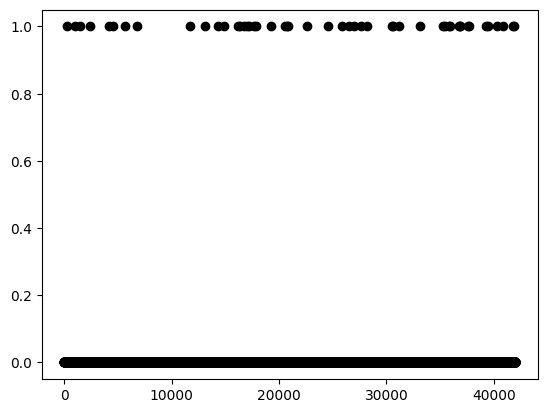

In [4]:
plt.plot(list(range(len(rawData[0][0]))), rawData[0][0], 'o', color='black')
featIn = len(rawData[0][0])
print(f"featIn {featIn}")

In [5]:
featIn = len(rawData[0][0])
trainValidData = []
testData = []
addData(testData, trainValidData, rawData, rhsSize=300)


np.random.shuffle(trainValidData)
trainData = []
validData = []
addData(trainData, validData, trainValidData, rhsSize=int(len(trainValidData)*(1/3)))

trainDataset = DataLoader(trainData, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True) 
validDataset = DataLoader(validData, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
testDataset = DataLoader(testData, batch_size=len(testData), shuffle=True, num_workers=num_workers, pin_memory=True)
print(f"Training dataset size: {len(trainData)}")
print(f"Valid dataset size: {len(validData)}")
print(f"Testing dataset size: {len(testData)}")
print(f"Total: {len(trainData) + len(validData) + len(testData)}")
print(f"number train batches:{len(trainDataset)}")
print(f"number valid batches:{len(validDataset)}")
print(f"number test batches:{len(testDataset)}")

featIn

Training dataset size: 200
Valid dataset size: 100
Testing dataset size: 588
Total: 888
number train batches:2
number valid batches:1
number test batches:1


42000

In [6]:
size = 12000
size

12000

In [11]:
model = nn.Sequential(
          nn.Linear(featIn,size),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(size,size),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(size,size),
          nn.ReLU(),
          nn.Linear(size,1),
        )
model.to(device)
MSE = nn.MSELoss(reduction = 'sum')
# ,weight_decay=1e-5
adam = torch.optim.Adam(model.parameters(),lr=0.0000001)

em = 20
epochs = 10000
losses = []
accs = []
print("training...")
for e in range(epochs): 
    avgLossTrain = []
    currentAccTrain = []
    model.train()
    for i, (inputs, targets) in enumerate(trainDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        avgLossTrain.append(float(loss.item()))
        adam.zero_grad()
        loss.backward()
        adam.step()
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.item()
        currentAccTrain.append(float(totalCorrect/len(targets)))
        
    avgLoss = []
    currentAcc = []
    model.eval()
    for i, (inputs, targets) in enumerate(validDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        avgLoss.append(float(loss.clone().detach().cpu().numpy()))
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        print(f"\
        epoch: {e}/{epochs}\t \
        Train Loss:{'%.4f' % (np.sum(avgLossTrain)/len(avgLossTrain))} Valid Loss:{'%.4f' % (np.sum(avgLoss)/len(avgLoss))}\t \
        Train accuracy:{'%.4f' % (np.sum(currentAccTrain)/len(currentAccTrain))} Valid accuracy:{'%.4f' % (np.sum(currentAcc)/len(currentAcc))} \
        ",end="\x1b\r")
    accs.append(float(np.sum(currentAcc)/len(currentAcc)))
    losses.append(float(np.sum(avgLoss)/len(avgLoss)))

training...


KeyboardInterrupt: 

10000

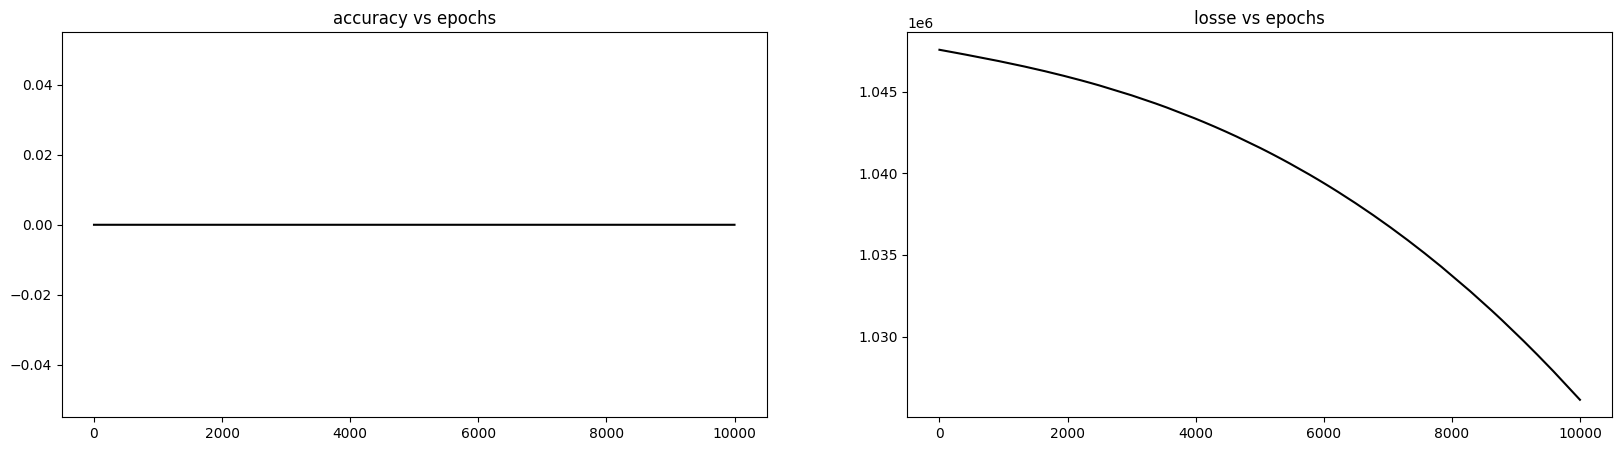

In [10]:
defultePlotSize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(1, 2, 1)
plt.title('accuracy vs epochs')
plt.plot(list(range(len(accs[:]))), accs[:], '-', color='black', )
plt.subplot(1, 2, 2)
plt.title('losse vs epochs')
plt.plot(list(range(len(losses)))[:], losses[:], '-', color='black')
plt.rcParams['figure.figsize'] = defultePlotSize
epochs*len(validDataset)

In [9]:
title = "trying varied movie length"
dt_string = datetime.now().strftime("%d.%m.%Y_%H-%M-%S-%f")
modelPath = f"./Models/{title.replace(' ', '_')}_{dt_string}.pt"
torch.save(model.state_dict(),modelPath)
print(f"saved to {modelPath}")

saved to ./Models/trying_varied_movie_length_31.05.2023_23-14-33-374077.pt
